In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

In [79]:
raw_data = pd.read_csv('data.csv')

In [80]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30360 entries, 0 to 30359
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 9144 non-null   object
 1   Price                 30360 non-null  object
 2   Address               30360 non-null  object
 3   Price per m2          12 non-null     object
 4   Area                  30358 non-null  object
 5   Bedrooms              20632 non-null  object
 6   Toilets               19720 non-null  object
 7   Published At          30360 non-null  object
 8   Diện tích             30358 non-null  object
 9   Mức giá               30360 non-null  object
 10  Hướng nhà             7640 non-null   object
 11  Hướng ban công        4677 non-null   object
 12  Ngày đăng             30360 non-null  object
 13  Ngày hết hạn          30360 non-null  object
 14  Loại tin              30360 non-null  object
 15  Mã tin                30360 non-null

In [81]:
unduplicated_data = raw_data.drop_duplicates(subset=['Mã tin'], keep='first')
unduplicated_data.loc[unduplicated_data[['Developer', 'Status']].isnull().all(axis=1), ['Developer', 'Status']] = ['cá nhân/môi giới', 'Đã bàn giao']
unduplicated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12446 entries, 0 to 30359
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 3838 non-null   object
 1   Price                 12446 non-null  object
 2   Address               12446 non-null  object
 3   Price per m2          1 non-null      object
 4   Area                  12445 non-null  object
 5   Bedrooms              8202 non-null   object
 6   Toilets               7805 non-null   object
 7   Published At          12446 non-null  object
 8   Diện tích             12445 non-null  object
 9   Mức giá               12446 non-null  object
 10  Hướng nhà             3131 non-null   object
 11  Hướng ban công        1828 non-null   object
 12  Ngày đăng             12446 non-null  object
 13  Ngày hết hạn          12446 non-null  object
 14  Loại tin              12446 non-null  object
 15  Mã tin                12446 non-null  obj

C:\Users\hienb\AppData\Local\Temp\ipykernel_28744\1051689887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unduplicated_data.loc[unduplicated_data[['Developer', 'Status']].isnull().all(axis=1), ['Developer', 'Status']] = ['cá nhân/môi giới', 'Đã bàn giao']


In [82]:
unduplicated_data = unduplicated_data.drop(["Price per m2","Project Address", "Title", "Diện tích", "Mức giá", "Project Title", "Ngày hết hạn", "Number of Buildings", "Ngày đăng", "Mã tin"], axis="columns")
unduplicated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12446 entries, 0 to 30359
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Price                 12446 non-null  object
 1   Address               12446 non-null  object
 2   Area                  12445 non-null  object
 3   Bedrooms              8202 non-null   object
 4   Toilets               7805 non-null   object
 5   Published At          12446 non-null  object
 6   Hướng nhà             3131 non-null   object
 7   Hướng ban công        1828 non-null   object
 8   Loại tin              12446 non-null  object
 9   Status                12446 non-null  object
 10  Number of Apartments  3838 non-null   object
 11  Developer             12446 non-null  object
dtypes: object(12)
memory usage: 1.2+ MB


In [83]:
unduplicated_data = unduplicated_data[unduplicated_data["Price"] != "Thỏa thuận"]

# Step 2: Clean the 'Area' column
def clean_area(area):
    if isinstance(area, str):
        area = area.replace(' m²', '').replace('.', '').replace(',', '.')
    return pd.to_numeric(area, errors='coerce')

unduplicated_data['Area'] = unduplicated_data['Area'].astype(str).apply(clean_area)

# Step 3: Remove outliers using IQR method
Q1 = unduplicated_data['Area'].quantile(0.25)
Q3 = unduplicated_data['Area'].quantile(0.75)
IQR = Q3 - Q1

# Define the acceptable range for Area
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
unduplicated_data = unduplicated_data[(unduplicated_data['Area'] >= lower_bound) & (unduplicated_data['Area'] <= upper_bound)]

# Step 4: Calculate number of bins
num_bins = int(np.ceil(np.log2(len(unduplicated_data)) + 1))
unduplicated_data['Area Range'] = pd.cut(unduplicated_data['Area'], bins=num_bins)

# Step 5: Create DataFrames for Toilets and Bedrooms
toilets_df = unduplicated_data[['Area', 'Toilets', 'Area Range']].copy()
bedrooms_df = unduplicated_data[['Area', 'Bedrooms', 'Area Range']].copy()

# Step 6: Extract numeric values from 'Toilets' and 'Bedrooms'
def extract_numeric(value):
    # Extract the first numeric sequence found in the string
    if isinstance(value, str):
        match = re.search(r'\d+', value)
        if match:
            return float(match.group())
    return np.nan

toilets_df['Toilets'] = toilets_df['Toilets'].apply(extract_numeric)
bedrooms_df['Bedrooms'] = bedrooms_df['Bedrooms'].apply(extract_numeric)

# Step 7: Filter out incorrect values from 'Toilets' and 'Bedrooms'
def filter_large_values(value, max_allowed=10):
    if pd.notna(value) and value > max_allowed:
        return np.nan  # Consider values greater than max_allowed (e.g., 10) as erroneous
    return value

toilets_df['Toilets'] = toilets_df['Toilets'].apply(lambda x: filter_large_values(x, max_allowed=10))
bedrooms_df['Bedrooms'] = bedrooms_df['Bedrooms'].apply(lambda x: filter_large_values(x, max_allowed=10))

# Step 8: Calculate the average number of Toilets and Bedrooms by Area Range
toilets_avg = toilets_df.groupby('Area Range')['Toilets'].mean()
bedrooms_avg = bedrooms_df.groupby('Area Range')['Bedrooms'].mean()

# Step 9: Fill missing values based on averages
def assign_values(row, col, avg_values):
    if pd.isna(row[col]) and not pd.isna(row['Area Range']):
        return avg_values.get(row['Area Range'], np.nan)
    else:
        return row[col]

unduplicated_data['Toilets'] = unduplicated_data.apply(lambda row: assign_values(row, 'Toilets', toilets_avg), axis=1)
unduplicated_data['Bedrooms'] = unduplicated_data.apply(lambda row: assign_values(row, 'Bedrooms', bedrooms_avg), axis=1)

# Step 10: Convert extracted values back to integers
def convert_to_string_with_suffix(value):
    if pd.notna(value):
        numeric_value = ''.join(filter(str.isdigit, str(value)))
        if numeric_value:
            return int(numeric_value)
    return np.nan

unduplicated_data['Toilets'] = unduplicated_data['Toilets'].apply(convert_to_string_with_suffix)
unduplicated_data['Bedrooms'] = unduplicated_data['Bedrooms'].apply(convert_to_string_with_suffix)

# Print info about the final dataframe
print("\nFinal DataFrame info:")
unduplicated_data.info()

# Print out a sample of the data to check for correctness
print("\nSample Data:")
print(unduplicated_data.head())

C:\Users\hienb\AppData\Local\Temp\ipykernel_28744\1916416514.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  toilets_avg = toilets_df.groupby('Area Range')['Toilets'].mean()
C:\Users\hienb\AppData\Local\Temp\ipykernel_28744\1916416514.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bedrooms_avg = bedrooms_df.groupby('Area Range')['Bedrooms'].mean()



Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 10341 entries, 0 to 30359
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Price                 10341 non-null  object  
 1   Address               10341 non-null  object  
 2   Area                  10341 non-null  float64 
 3   Bedrooms              10341 non-null  int64   
 4   Toilets               10341 non-null  int64   
 5   Published At          10341 non-null  object  
 6   Hướng nhà             2687 non-null   object  
 7   Hướng ban công        1644 non-null   object  
 8   Loại tin              10341 non-null  object  
 9   Status                10341 non-null  object  
 10  Number of Apartments  3402 non-null   object  
 11  Developer             10341 non-null  object  
 12  Area Range            10341 non-null  category
dtypes: category(1), float64(1), int64(2), object(9)
memory usage: 1.0+ MB

Sample Data:
    

In [84]:
unduplicated_data.head(10)

,Price,Address,Area,Bedrooms,Toilets,Published At,Hướng nhà,Hướng ban công,Loại tin,Status,Number of Apartments,Developer,Area Range
0,"15,2 tỷ","Đường Dương Bá Trạc, Phường 2, Quận 8, Hồ Chí ...",40.0,6,4,17/10/2024,NaN,NaN,Tin VIP Bạc,Đã bàn giao,NaN,cá nhân/môi giới,"(24.133, 41.267]"
1,"5,6 tỷ","Screc Tower, Đường Trường Sa, Phường 12, Quận ...",90.0,3,2,23/10/2024,NaN,NaN,Tin thường,đã bàn giao,60-106 m²,Công ty CP Đầu tư Xây dựng và Kinh doanh nhà S...,"(75.533, 92.667]"
2,7 tỷ,"Dự án HaDo Centrosa Garden, Đường 3/2, Phường ...",87.0,2,2,23/10/2024,NaN,NaN,Tin VIP Kim Cương,Đã bàn giao,2.178,Tập đoàn Hà Đô,"(75.533, 92.667]"
3,"12,35 tỷ","Đường Nguyễn Trãi, Phường 7, Quận 5, Hồ Chí Minh",60.0,4,31226303317535544,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(58.4, 75.533]"
5,"1,35 tỷ","Dự án Dream Home Riverside, Đường Nguyễn Văn L...",57.0,2,2,17/10/2024,NaN,NaN,Tin VIP Bạc,Đang mở bán,55-75 m²,Công ty TNHH SX TM Lý Khương,"(41.267, 58.4]"
6,"7,8 tỷ","Đường Phạm Văn Bạch, Phường 15, Tân Bình, Hồ C...",100.0,3,3,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(92.667, 109.8]"
7,"5,95 tỷ","Dự án ICON 56, Đường Bến Vân Đồn, Phường 12, Q...",87.0,3,2,15/10/2024,NaN,NaN,Tin thường,Đã bàn giao,47-112 m²,Novaland Group,"(75.533, 92.667]"
9,16 tỷ,"Phường Phước Long B, Quận 9, Hồ Chí Minh",156.0,8,9,17/10/2024,NaN,NaN,Tin VIP Bạc,Đã bàn giao,NaN,cá nhân/môi giới,"(144.067, 161.2]"
10,"8,6 tỷ","Đường Lê Văn Sỹ, Phường 12, Quận 3, Hồ Chí Minh",34.0,3,4,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(24.133, 41.267]"
11,"8,7 tỷ","Đường Huỳnh Tấn Phát, Phường Phú Thuận, Quận 7...",80.0,4,5,04/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(75.533, 92.667]"


In [85]:
# Chuyển đổi dữ liệu ở cột Area sang float
def convert_area_value(value):
    try: 
        # Chỉ thực hiện thay thế nếu value là chuỗi
        if isinstance(value, str):
            # Lọc bỏ các dấu chấm ở số hàng nghìn
            value = value.replace('m²', '').replace('.', '')

            # Thay dấu phẩy thành dấu chấm
            value = value.replace(',', '.')
            
            return float(value)
        
        # Nếu value đã là số (float hoặc int), trả về trực tiếp
        elif isinstance(value, (int, float)):
            return float(value)

    except Exception as e:
        print(f"Lỗi khi xử lý giá trị: {value}. Chi tiết lỗi: {e}")
        return None

unduplicated_data['Diện Tích'] = unduplicated_data['Area'].apply(convert_area_value)

In [86]:
unduplicated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10341 entries, 0 to 30359
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Price                 10341 non-null  object  
 1   Address               10341 non-null  object  
 2   Area                  10341 non-null  float64 
 3   Bedrooms              10341 non-null  int64   
 4   Toilets               10341 non-null  int64   
 5   Published At          10341 non-null  object  
 6   Hướng nhà             2687 non-null   object  
 7   Hướng ban công        1644 non-null   object  
 8   Loại tin              10341 non-null  object  
 9   Status                10341 non-null  object  
 10  Number of Apartments  3402 non-null   object  
 11  Developer             10341 non-null  object  
 12  Area Range            10341 non-null  category
 13  Diện Tích             10341 non-null  float64 
dtypes: category(1), float64(2), int64(2), object(9)
memory usag

In [87]:
# Hàm chuyển đổi giá trị thành tỷ với xử lý trường hợp "triệu/m²"
def convert_to_billion(value, area):
    try:
        # Chỉ thực hiện thay thế nếu value là chuỗi
        if isinstance(value, str):
            # Thay dấu phẩy thành dấu chấm
            value = value.replace(',', '.')

            # Dữ liệu chỉ đánh giá các bds rao bán nên sẽ không xử lý các bds cho thuê
            if '/tháng' in value:
                return None
            
            # Kiểm tra nếu có "triệu/m²"
            elif 'triệu/m²' in value:
                price_per_sqm = float(value.replace(' triệu/m²', '')) / 1000  # Đổi từ triệu/m² thành tỷ/m²
                return price_per_sqm * area  # Nhân với diện tích để có giá trị tổng

            # Kiểm tra nếu có "triệu/m²"
            elif 'tỷ/m²' in value:
                price_per_sqm = float(value.replace(' tỷ/m²', ''))
                return price_per_sqm * area  # Nhân với diện tích để có giá trị tổng

            # Xử lý các trường hợp có đơn vị "tỷ" hoặc "triệu"
            elif 'tỷ' in value:
                return float(value.replace(' tỷ', ''))
            
            # Chuyển "triệu" thành "tỷ"
            elif 'triệu' in value:
                return float(value.replace(' triệu', '')) / 1000  
        
        # Nếu value đã là số (float hoặc int), trả về trực tiếp
        elif isinstance(value, (int, float)):
            return float(value)
        
        return None
        
    except Exception as e:
        print(f"Lỗi khi xử lý giá trị: {value}. Chi tiết lỗi: {e}")
        return None

# Áp dụng hàm vào cột 'giá_cả' và truyền thêm cột 'diện_tích' để tính giá trị cuối cùng
unduplicated_data['Giá'] = unduplicated_data.apply(lambda row: convert_to_billion(row['Price'], row['Diện Tích']), axis=1)

In [88]:
unduplicated_data = unduplicated_data.dropna(subset=["Giá"])
unduplicated_data.head()

,Price,Address,Area,Bedrooms,Toilets,Published At,Hướng nhà,Hướng ban công,Loại tin,Status,Number of Apartments,Developer,Area Range,Diện Tích,Giá
0,"15,2 tỷ","Đường Dương Bá Trạc, Phường 2, Quận 8, Hồ Chí ...",40.0,6,4,17/10/2024,NaN,NaN,Tin VIP Bạc,Đã bàn giao,NaN,cá nhân/môi giới,"(24.133, 41.267]",40.0,15.20
1,"5,6 tỷ","Screc Tower, Đường Trường Sa, Phường 12, Quận ...",90.0,3,2,23/10/2024,NaN,NaN,Tin thường,đã bàn giao,60-106 m²,Công ty CP Đầu tư Xây dựng và Kinh doanh nhà S...,"(75.533, 92.667]",90.0,5.60
2,7 tỷ,"Dự án HaDo Centrosa Garden, Đường 3/2, Phường ...",87.0,2,2,23/10/2024,NaN,NaN,Tin VIP Kim Cương,Đã bàn giao,2.178,Tập đoàn Hà Đô,"(75.533, 92.667]",87.0,7.00
3,"12,35 tỷ","Đường Nguyễn Trãi, Phường 7, Quận 5, Hồ Chí Minh",60.0,4,31226303317535544,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(58.4, 75.533]",60.0,12.35
5,"1,35 tỷ","Dự án Dream Home Riverside, Đường Nguyễn Văn L...",57.0,2,2,17/10/2024,NaN,NaN,Tin VIP Bạc,Đang mở bán,55-75 m²,Công ty TNHH SX TM Lý Khương,"(41.267, 58.4]",57.0,1.35


In [89]:
unduplicated_data["Triệu/m2"] = (unduplicated_data["Giá"] / unduplicated_data["Diện Tích"] * 100).round(1)
unduplicated_data.head(10)

,Price,Address,Area,Bedrooms,Toilets,Published At,Hướng nhà,Hướng ban công,Loại tin,Status,Number of Apartments,Developer,Area Range,Diện Tích,Giá,Triệu/m2
0,"15,2 tỷ","Đường Dương Bá Trạc, Phường 2, Quận 8, Hồ Chí ...",40.0,6,4,17/10/2024,NaN,NaN,Tin VIP Bạc,Đã bàn giao,NaN,cá nhân/môi giới,"(24.133, 41.267]",40.0,15.20,38.0
1,"5,6 tỷ","Screc Tower, Đường Trường Sa, Phường 12, Quận ...",90.0,3,2,23/10/2024,NaN,NaN,Tin thường,đã bàn giao,60-106 m²,Công ty CP Đầu tư Xây dựng và Kinh doanh nhà S...,"(75.533, 92.667]",90.0,5.60,6.2
2,7 tỷ,"Dự án HaDo Centrosa Garden, Đường 3/2, Phường ...",87.0,2,2,23/10/2024,NaN,NaN,Tin VIP Kim Cương,Đã bàn giao,2.178,Tập đoàn Hà Đô,"(75.533, 92.667]",87.0,7.00,8.0
3,"12,35 tỷ","Đường Nguyễn Trãi, Phường 7, Quận 5, Hồ Chí Minh",60.0,4,31226303317535544,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(58.4, 75.533]",60.0,12.35,20.6
5,"1,35 tỷ","Dự án Dream Home Riverside, Đường Nguyễn Văn L...",57.0,2,2,17/10/2024,NaN,NaN,Tin VIP Bạc,Đang mở bán,55-75 m²,Công ty TNHH SX TM Lý Khương,"(41.267, 58.4]",57.0,1.35,2.4
6,"7,8 tỷ","Đường Phạm Văn Bạch, Phường 15, Tân Bình, Hồ C...",100.0,3,3,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(92.667, 109.8]",100.0,7.80,7.8
7,"5,95 tỷ","Dự án ICON 56, Đường Bến Vân Đồn, Phường 12, Q...",87.0,3,2,15/10/2024,NaN,NaN,Tin thường,Đã bàn giao,47-112 m²,Novaland Group,"(75.533, 92.667]",87.0,5.95,6.8
9,16 tỷ,"Phường Phước Long B, Quận 9, Hồ Chí Minh",156.0,8,9,17/10/2024,NaN,NaN,Tin VIP Bạc,Đã bàn giao,NaN,cá nhân/môi giới,"(144.067, 161.2]",156.0,16.00,10.3
10,"8,6 tỷ","Đường Lê Văn Sỹ, Phường 12, Quận 3, Hồ Chí Minh",34.0,3,4,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(24.133, 41.267]",34.0,8.60,25.3
11,"8,7 tỷ","Đường Huỳnh Tấn Phát, Phường Phú Thuận, Quận 7...",80.0,4,5,04/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(75.533, 92.667]",80.0,8.70,10.9


In [90]:
unduplicated_data["Ngày đăng"] = pd.to_datetime(unduplicated_data["Published At"], format="%d/%m/%Y")
unduplicated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10335 entries, 0 to 30359
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Price                 10335 non-null  object        
 1   Address               10335 non-null  object        
 2   Area                  10335 non-null  float64       
 3   Bedrooms              10335 non-null  int64         
 4   Toilets               10335 non-null  int64         
 5   Published At          10335 non-null  object        
 6   Hướng nhà             2687 non-null   object        
 7   Hướng ban công        1643 non-null   object        
 8   Loại tin              10335 non-null  object        
 9   Status                10335 non-null  object        
 10  Number of Apartments  3399 non-null   object        
 11  Developer             10335 non-null  object        
 12  Area Range            10335 non-null  category      
 13  Diện Tích            

In [91]:
def convert_the_number_of_rooms(value):
    try:
        if isinstance(value, str):
            if "phòng" in value:
                value = value.replace(" phòng", "")
                return float(value)
            else: return None
        elif isinstance (value, (int, float)):
            return float(value)
        return None
    except Exception as e:
        print(f"Lỗi khi xử lý giá trị {value}, chi tiết lỗi {e}")
        return None
    
unduplicated_data["Số Phòng Ngủ"] = unduplicated_data["Bedrooms"].apply(convert_the_number_of_rooms)
unduplicated_data["Số Nhà Vệ Sinh"] = unduplicated_data["Toilets"].apply(convert_the_number_of_rooms)

In [92]:
# unduplicated_data.head(10)
unduplicated_data.head(10)

,Price,Address,Area,Bedrooms,Toilets,Published At,Hướng nhà,Hướng ban công,Loại tin,Status,Number of Apartments,Developer,Area Range,Diện Tích,Giá,Triệu/m2,Ngày đăng,Số Phòng Ngủ,Số Nhà Vệ Sinh
0,"15,2 tỷ","Đường Dương Bá Trạc, Phường 2, Quận 8, Hồ Chí ...",40.0,6,4,17/10/2024,NaN,NaN,Tin VIP Bạc,Đã bàn giao,NaN,cá nhân/môi giới,"(24.133, 41.267]",40.0,15.20,38.0,2024-10-17,6.0,4.000000e+00
1,"5,6 tỷ","Screc Tower, Đường Trường Sa, Phường 12, Quận ...",90.0,3,2,23/10/2024,NaN,NaN,Tin thường,đã bàn giao,60-106 m²,Công ty CP Đầu tư Xây dựng và Kinh doanh nhà S...,"(75.533, 92.667]",90.0,5.60,6.2,2024-10-23,3.0,2.000000e+00
2,7 tỷ,"Dự án HaDo Centrosa Garden, Đường 3/2, Phường ...",87.0,2,2,23/10/2024,NaN,NaN,Tin VIP Kim Cương,Đã bàn giao,2.178,Tập đoàn Hà Đô,"(75.533, 92.667]",87.0,7.00,8.0,2024-10-23,2.0,2.000000e+00
3,"12,35 tỷ","Đường Nguyễn Trãi, Phường 7, Quận 5, Hồ Chí Minh",60.0,4,31226303317535544,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(58.4, 75.533]",60.0,12.35,20.6,2024-10-22,4.0,3.122630e+16
5,"1,35 tỷ","Dự án Dream Home Riverside, Đường Nguyễn Văn L...",57.0,2,2,17/10/2024,NaN,NaN,Tin VIP Bạc,Đang mở bán,55-75 m²,Công ty TNHH SX TM Lý Khương,"(41.267, 58.4]",57.0,1.35,2.4,2024-10-17,2.0,2.000000e+00
6,"7,8 tỷ","Đường Phạm Văn Bạch, Phường 15, Tân Bình, Hồ C...",100.0,3,3,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(92.667, 109.8]",100.0,7.80,7.8,2024-10-22,3.0,3.000000e+00
7,"5,95 tỷ","Dự án ICON 56, Đường Bến Vân Đồn, Phường 12, Q...",87.0,3,2,15/10/2024,NaN,NaN,Tin thường,Đã bàn giao,47-112 m²,Novaland Group,"(75.533, 92.667]",87.0,5.95,6.8,2024-10-15,3.0,2.000000e+00
9,16 tỷ,"Phường Phước Long B, Quận 9, Hồ Chí Minh",156.0,8,9,17/10/2024,NaN,NaN,Tin VIP Bạc,Đã bàn giao,NaN,cá nhân/môi giới,"(144.067, 161.2]",156.0,16.00,10.3,2024-10-17,8.0,9.000000e+00
10,"8,6 tỷ","Đường Lê Văn Sỹ, Phường 12, Quận 3, Hồ Chí Minh",34.0,3,4,22/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(24.133, 41.267]",34.0,8.60,25.3,2024-10-22,3.0,4.000000e+00
11,"8,7 tỷ","Đường Huỳnh Tấn Phát, Phường Phú Thuận, Quận 7...",80.0,4,5,04/10/2024,NaN,NaN,Tin thường,Đã bàn giao,NaN,cá nhân/môi giới,"(75.533, 92.667]",80.0,8.70,10.9,2024-10-04,4.0,5.000000e+00


In [93]:
gbd_path = './gbd.csv'
df_gbd = pd.read_csv(gbd_path)
df_gbd['Tên đường'] = df_gbd['TÊN ĐƯỜNG'].str.lower()
df_gbd['Quận'] = df_gbd['QUẬN'].str.lower()
# Giá trung bình của đất nơi dự án
def calculate_avg_district_prices(df_gbd):
    district_avg_prices = {}

    # Group by district and calculate the average of 'Giá đất đề nghị điều chỉnh'
    for district in df_gbd['Quận'].unique():
        # Filter data for the district
        district_data = df_gbd[df_gbd['Quận'] == district].copy()
        
        # Ensure 'Giá đất đề nghị điều chỉnh' is numeric and calculate the average
        district_data.loc[:, 'Giá đất đề nghị điều chỉnh'] = pd.to_numeric(district_data['Giá đất đề nghị điều chỉnh'], errors='coerce')
        
        # Calculate the average price for the district
        avg_price = district_data['Giá đất đề nghị điều chỉnh'].mean()
        district_avg_prices[district] = avg_price

    return district_avg_prices

district_avg_prices = calculate_avg_district_prices(df_gbd)
district_avg_prices

{'bình chánh': np.float64(25803.571428571428),
 'bình thạnh': np.float64(105035.10638297872),
 'bình tân': np.float64(45781.513083048914),
 'cần giờ': np.float64(7238.851851851853),
 'củ chi': np.float64(8990.760869565218),
 'gò vấp': np.float64(70582.75862068965),
 'hóc môn': np.float64(20194.915254237287),
 'nhà bè': np.float64(32532.196969696968),
 'phú nhuận': np.float64(124477.19298245614),
 'quận 1': np.float64(267213.53383458644),
 'quận 10': np.float64(131008.0),
 'quận 11': np.float64(115061.30136986301),
 'quận 12': np.float64(44303.08641975309),
 'quận 2': np.float64(59327.65113974232),
 'quận 3': np.float64(213742.85714285713),
 'quận 4': np.float64(138849.38271604938),
 'quận 5': np.float64(139679.38144329897),
 'quận 6': np.float64(92683.33333333333),
 'quận 7': np.float64(80628.373015873),
 'quận 8': np.float64(61907.186544342505),
 'quận 9': np.float64(59327.65113974232),
 'thủ đức': np.float64(59327.65113974232),
 'tân bình': np.float64(101933.79629629629),
 'tân phú':

In [94]:
def contains_hcm_and_district(address, district):
    # Ensure that we are checking if the district and either Hồ Chí Minh or Thủ Đức appear in the address
    return district.lower() in address.lower() and ('hồ chí minh' in address.lower() or 'thủ đức' in address.lower())

def assign_district_price(row):
    # Normalize address to lowercase
    address = row['Address'].lower()
    street_match = df_gbd[df_gbd['Tên đường'].apply(lambda x: x.lower() in address)]
    print(f"Processing address: {address}, {len(street_match)}")  # Debug print for address
    
    for idx, match in street_match.iterrows():
        street_name = match['Tên đường'].lower()
        district = match['Quận'].lower()

        if district in ['Thủ Đức']:
            print(f"District {district} is a sub-district of Thủ Đức, checking street match...")
            price = match['Giá đất đề nghị điều chỉnh']
            return 'thủ đức', price, street_name

        if street_name in address and district in address:
            print(f"Found exact match: Street = {street_name}, District = {district}")
            price = match['Giá đất đề nghị điều chỉnh']
            return district, price, street_name

    for district in district_avg_prices:
        if contains_hcm_and_district(address, district):
            price = district_avg_prices[district]
            print(f"Price found for district {district}: {price}")
            return district, price, None

    print(f"No match found for address: {address}")
    return None, None, None

unduplicated_data[['Quận', 'Giá Đề Xuất', 'Đường']] = unduplicated_data.apply(lambda row: pd.Series(assign_district_price(row)), axis=1)
unduplicated_data = unduplicated_data[unduplicated_data['Giá Đề Xuất'].notna()]
unduplicated_data.head(10000).to_csv('new_data.csv', index=False)

Processing address: đường dương bá trạc, phường 2, quận 8, hồ chí minh, 2
Found exact match: Street = dương bá trạc, District = quận 8
Processing address: screc tower, đường trường sa, phường 12, quận 3, hồ chí minh, 3
Found exact match: Street = trường sa, District = quận 3
Processing address: dự án hado centrosa garden, đường 3/2, phường 12, quận 10, hồ chí minh, 1
Price found for district quận 1: 267213.53383458644
Processing address: đường nguyễn trãi, phường 7, quận 5, hồ chí minh, 3
Found exact match: Street = nguyễn trãi, District = quận 5
Processing address: dự án dream home riverside, đường nguyễn văn linh, phường 7, quận 8, hồ chí minh, 4
Found exact match: Street = nguyễn văn linh, District = quận 8
Processing address: đường phạm văn bạch, phường 15, tân bình, hồ chí minh, 3
Found exact match: Street = phạm văn bạch, District = tân bình
Processing address: dự án icon 56, đường bến vân đồn, phường 12, quận 4, hồ chí minh, 5
Found exact match: Street = bến vân đồn, District = 

In [95]:
# Xử lý số lượng các căn hộ
def handle_number_of_apartment(value):
    try:
        if isinstance(value, str):
            value = value.replace(".", "")
            value = int(value)
            return value
        # Nếu value đã là số (float hoặc int), trả về trực tiếp
        elif isinstance(value, (int, float)):
            return float(value)
        
        return None        
    except Exception as e:
        print(f"Lỗi khi xử lý giá trị: {value}. Chi tiết lỗi: {e}")
        return None
    
    

unduplicated_data["Số Căn Hộ"] = unduplicated_data["Number of Apartments"].apply(handle_number_of_apartment)

Lỗi khi xử lý giá trị: 60-106 m². Chi tiết lỗi: invalid literal for int() with base 10: '60-106 m²'
Lỗi khi xử lý giá trị: 55-75 m². Chi tiết lỗi: invalid literal for int() with base 10: '55-75 m²'
Lỗi khi xử lý giá trị: 47-112 m². Chi tiết lỗi: invalid literal for int() with base 10: '47-112 m²'
Lỗi khi xử lý giá trị: Công ty Cổ Phần Đầu Tư và Kinh Doanh nhà Khang Điền. Chi tiết lỗi: invalid literal for int() with base 10: 'Công ty Cổ Phần Đầu Tư và Kinh Doanh nhà Khang Điền'
Lỗi khi xử lý giá trị: Công ty Cổ Phần Đầu Tư và Kinh Doanh nhà Khang Điền. Chi tiết lỗi: invalid literal for int() with base 10: 'Công ty Cổ Phần Đầu Tư và Kinh Doanh nhà Khang Điền'
Lỗi khi xử lý giá trị: 44-95 m². Chi tiết lỗi: invalid literal for int() with base 10: '44-95 m²'
Lỗi khi xử lý giá trị: 53-86 m². Chi tiết lỗi: invalid literal for int() with base 10: '53-86 m²'
Lỗi khi xử lý giá trị: 50-100 m². Chi tiết lỗi: invalid literal for int() with base 10: '50-100 m²'
Lỗi khi xử lý giá trị: 53-86 m². Chi t

In [96]:
unduplicated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9281 entries, 0 to 30359
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Price                 9281 non-null   object        
 1   Address               9281 non-null   object        
 2   Area                  9281 non-null   float64       
 3   Bedrooms              9281 non-null   int64         
 4   Toilets               9281 non-null   int64         
 5   Published At          9281 non-null   object        
 6   Hướng nhà             2326 non-null   object        
 7   Hướng ban công        1425 non-null   object        
 8   Loại tin              9281 non-null   object        
 9   Status                9281 non-null   object        
 10  Number of Apartments  3000 non-null   object        
 11  Developer             9281 non-null   object        
 12  Area Range            9281 non-null   category      
 13  Diện Tích             

In [97]:
unduplicated_data.describe()

,Area,Bedrooms,Toilets,Diện Tích,Giá,Triệu/m2,Ngày đăng,Số Phòng Ngủ,Số Nhà Vệ Sinh,Giá Đề Xuất,Số Căn Hộ
count,9281.000000,9.281000e+03,9.281000e+03,9281.000000,9281.00000,9281.000000,9281,9.281000e+03,9.281000e+03,9281.000000,900.000000
mean,96.902096,2.436377e+15,5.385362e+15,96.902096,14.35883,13.593934,2024-10-23 09:20:25.342096640,2.436377e+15,5.385362e+15,111968.592024,1996.916667
min,7.000000,1.000000e+00,1.000000e+00,7.000000,0.00105,0.000000,2024-09-27 00:00:00,1.000000e+00,1.000000e+00,4700.000000,2.000000
25%,61.000000,3.000000e+00,2.000000e+00,61.000000,4.15000,5.900000,2024-10-23 00:00:00,3.000000e+00,2.000000e+00,59327.651140,468.000000
50%,82.000000,4.000000e+00,4.000000e+00,82.000000,7.80000,9.900000,2024-10-24 00:00:00,4.000000e+00,4.000000e+00,86800.000000,917.000000
75%,120.000000,3.325998e+14,3.411498e+15,120.000000,16.10000,16.700000,2024-10-26 00:00:00,3.325998e+14,3.411498e+15,136400.000000,1800.000000
max,264.000000,3.902913e+16,3.543624e+16,264.000000,450.00000,880.000000,2024-10-31 00:00:00,3.902913e+16,3.543624e+16,687200.000000,13000.000000
std,50.372958,7.391726e+15,1.165486e+16,50.372958,20.00076,16.909837,NaN,7.391726e+15,1.165486e+16,76038.065363,3186.088309


Có các oulier tại cột price như 900 tỷ, cột area như 30,000 tỷ, bedroom 200 phòng, 96 toilet --> không phải dự án bất động sản riêng lẻ --> chuỗi dự án căn hộ cấp cao? --> Loại bỏ

In [98]:
# Code xử lý loại bỏ các ngoại lai quá lớn có thể ảnh hưởng đến dữ liệu
# Tính Q1, Q3 và IQR của cột Giá
Q1_price = unduplicated_data['Giá'].quantile(0.25)
Q3_price = unduplicated_data['Giá'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Tính Q1, Q3 và IQR của cột Diện Tích
Q1_area = unduplicated_data['Diện Tích'].quantile(0.25)
Q3_area = unduplicated_data['Diện Tích'].quantile(0.75)
IQR_area = Q3_area - Q1_area


# Lọc các giá trị không phải là ngoại lai
df_no_outliers = unduplicated_data[(unduplicated_data['Diện Tích'] >= Q1_area - 1.5 * IQR_area) & (unduplicated_data['Diện Tích'] <= Q3_area + 1.5 * IQR_area)]
df_no_outliers = df_no_outliers[(df_no_outliers['Giá'] >= Q1_price - 1.5 * IQR_price) & (df_no_outliers['Giá'] <= Q3_price + 1.5 * IQR_price)]

In [99]:
# Việt hóa
unduplicated_data["Chủ Đầu Tư"] = unduplicated_data["Developer"]
unduplicated_data["Trạng Thái"] = unduplicated_data["Status"]

In [100]:
# Drop các cột dư thừa sau khi Việt hóa
unduplicated_data = unduplicated_data.drop(["Area", "Price", "Address", "Bedrooms", "Toilets", "Published At", "Developer", "Status", "Number of Apartments"], axis="columns")

In [101]:
unduplicated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9281 entries, 0 to 30359
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Hướng nhà       2326 non-null   object        
 1   Hướng ban công  1425 non-null   object        
 2   Loại tin        9281 non-null   object        
 3   Area Range      9281 non-null   category      
 4   Diện Tích       9281 non-null   float64       
 5   Giá             9281 non-null   float64       
 6   Triệu/m2        9281 non-null   float64       
 7   Ngày đăng       9281 non-null   datetime64[ns]
 8   Số Phòng Ngủ    9281 non-null   float64       
 9   Số Nhà Vệ Sinh  9281 non-null   float64       
 10  Quận            9281 non-null   object        
 11  Giá Đề Xuất     9281 non-null   float64       
 12  Đường           7000 non-null   object        
 13  Số Căn Hộ       900 non-null    float64       
 14  Chủ Đầu Tư      9281 non-null   object        
 15  Trạng Th

## THỐNG KÊ SỐ LƯỢNG BDS MỖI QUẬN, HUYỆN

C:\Users\hienb\AppData\Local\Temp\ipykernel_28744\1028449840.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=district_counts, x='Quận', y='Số lượng BĐS', palette='viridis')


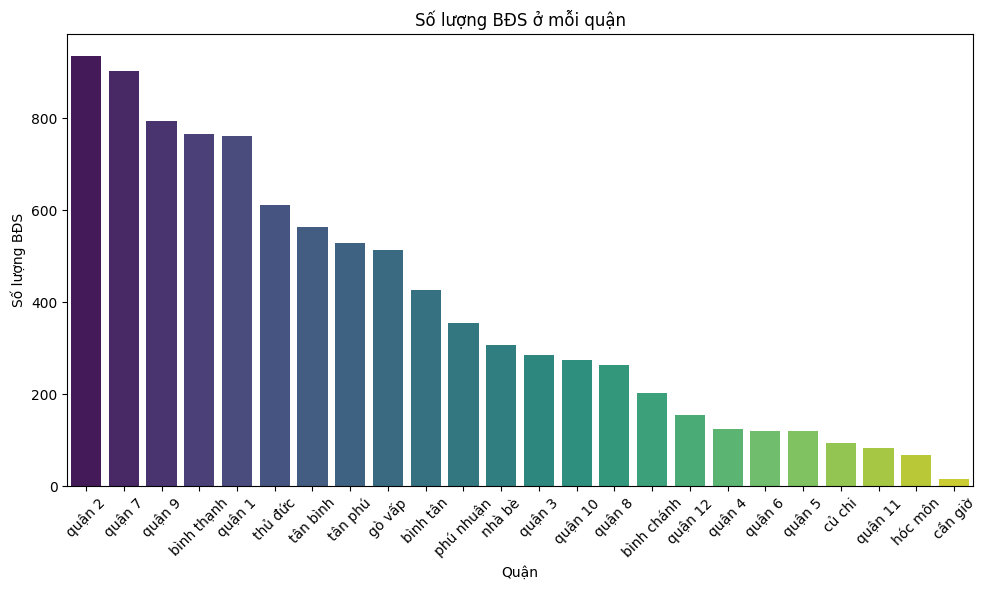

In [102]:
# Đếm số lượng BĐS trong mỗi quận
district_counts = unduplicated_data['Quận'].value_counts().reset_index()
district_counts.columns = ['Quận', 'Số lượng BĐS']

# Vẽ biểu đồ với seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=district_counts, x='Quận', y='Số lượng BĐS', palette='viridis')
plt.title('Số lượng BĐS ở mỗi quận')
plt.xlabel('Quận')
plt.ylabel('Số lượng BĐS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## SỰ PHÂN BỔ VỀ GIÁ TRỊ BDS

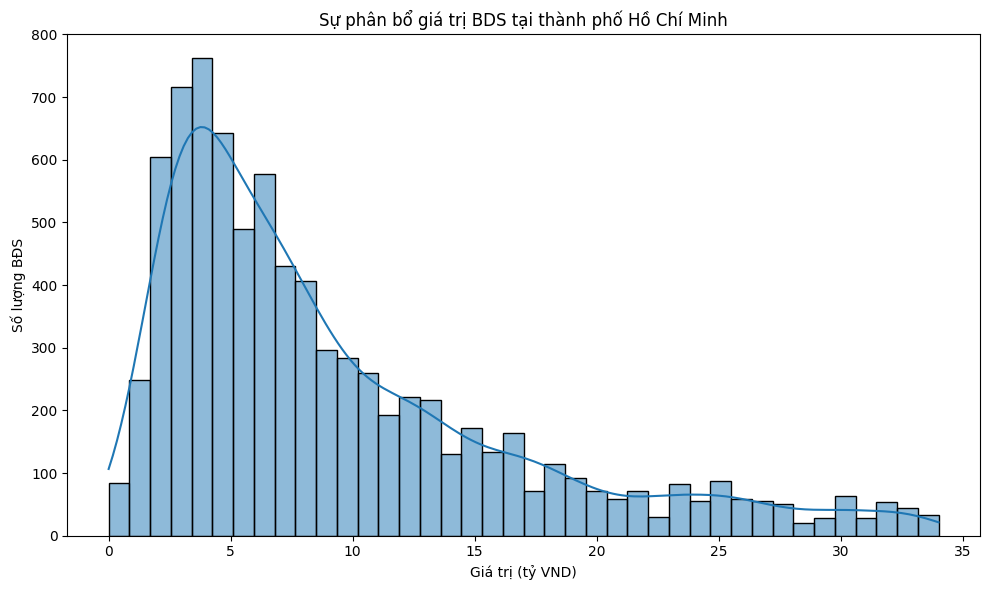

In [103]:


# Vẽ biểu đồ với seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_no_outliers, x="Giá", bins=40, kde=True)
plt.title('Sự phân bổ giá trị BDS tại thành phố Hồ Chí Minh')
plt.xlabel('Giá trị (tỷ VND)')
plt.ylabel('Số lượng BĐS')
plt.tight_layout()
plt.show()

## SỰ LIÊN HỆ GIỮA GIÁ TRỊ VÀ DIỆN TÍCH BDS TẠI TPHCM

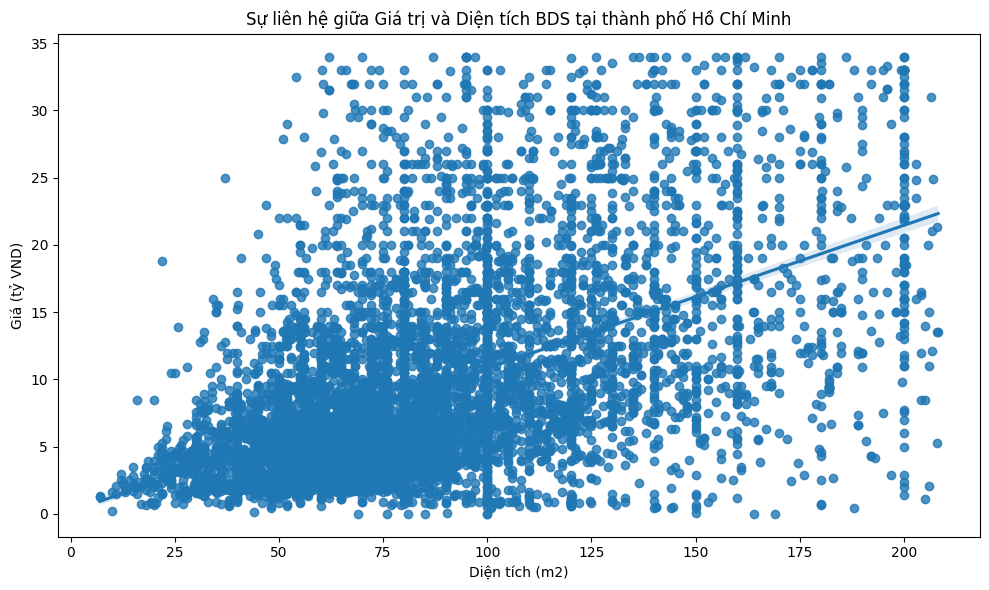

In [104]:

# Vẽ biểu đồ với seaborn
plt.figure(figsize=(10, 6))
sns.regplot(data=df_no_outliers, x=df_no_outliers["Diện Tích"], y=df_no_outliers["Giá"])
plt.title('Sự liên hệ giữa Giá trị và Diện tích BDS tại thành phố Hồ Chí Minh')
plt.xlabel('Diện tích (m2)')
plt.ylabel('Giá (tỷ VND)')
plt.tight_layout()
plt.show()

Nhận xét: 
- Giá và Diện tích của BDS có tính tương quan thuận với nhau.
- Biểu đồ cho thấy sự phân tán lớn chứng tỏ giá bất động sản ở mỗi khu vực khác nhau có sự khác biệt lớn.

## Sự liên hệ giữa Giá và Diện tích BDS tại một số quận ở thành phố Hồ Chí Minh

In [105]:
# Rút trích dữ liệu của một số quận để Visualization 
district_2 = df_no_outliers[df_no_outliers["Quận"] == "quận 2"]
district_7 = df_no_outliers[df_no_outliers["Quận"] == "quận 7"]
district_9 = df_no_outliers[df_no_outliers["Quận"] == "quận 9"]
district_BinhThanh = df_no_outliers[df_no_outliers["Quận"] == "Bình Thạnh"]

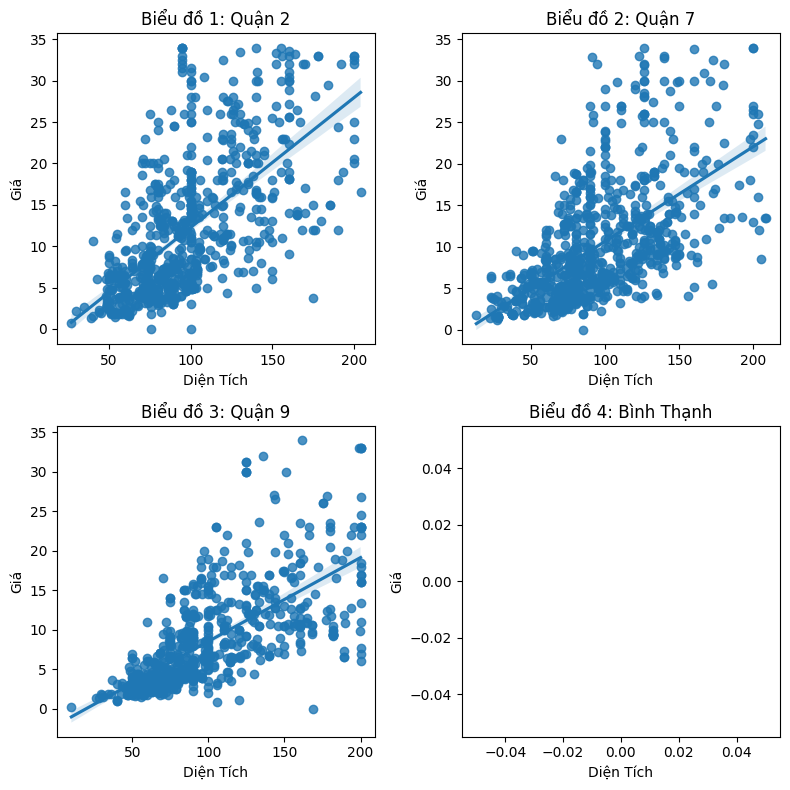

In [106]:
datasets = [district_2, district_7, district_9, district_BinhThanh]
district_names = ["Quận 2", "Quận 7", "Quận 9", "Bình Thạnh"]
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_cols * 4, n_rows * 4))

for r in range(n_rows):
    for c in range(n_cols):
        i = r *  n_cols + c
        if i < len(datasets):
            ax_i = ax[r, c]
            sns.regplot(data=datasets[i], x=datasets[i]["Diện Tích"], y=datasets[i]["Giá"], ax=ax_i)
            ax_i.set_title(f"Biểu đồ {i + 1}: {district_names[i]}")
plt.tight_layout()
plt.show()


In [107]:
num_devs = unduplicated_data["Chủ Đầu Tư"].nunique()
num_devs

201

#### Có tổng số 189 nhà đầu tư BDS khác nhau trong tập dữ liệu